# Finding the optimal portfolio allocation via Policy Gradient Methods

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.optimize as sci
from numpy.linalg import inv

#### divide data in training and test
#### on traing data: estimate VAR, generate synthetic data and return data frame

In [2]:
# function estimates VAR and returns model and dataset
def estimate_VAR(data):
    # take difference of timeseries to avoid stationarity
    data_stationary = data.diff().dropna()

    # fit VAR
    var_model = VAR(data_stationary)
    var_model_fitted = var_model.fit()
    return var_model_fitted

In [3]:
# function generates a data set of size num_obs - 1
# forecast horizon is 1 months but can be changed
# num_obs cannot be larger than df.shape[0]
def generate_data(df, df_stationary, model_fitted, numb_obs, forecast_window = 1):

    lag_order = model_fitted.k_ar

    # inputs to generate a random vector
    mean_vector = np.zeros(df_stationary.shape[1])
    covariance_matrix = df_stationary.cov()

    # instantiate dataframes to store the results
    df_results = pd.DataFrame(columns=df.columns, index=range(numb_obs))
    df_forecast = pd.DataFrame(columns=df.columns, index=range(numb_obs))

    # all subsequent data points in forecast
    for i in range(lag_order, numb_obs):
        forecast_input = df_stationary.values[i-lag_order: i] 
        fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
        df_forecast.iloc[i-lag_order,:] = fc + np.random.multivariate_normal(mean_vector, covariance_matrix)
        df_results.iloc[i,:] = df.iloc[i-lag_order,:] + fc[0] + np.random.multivariate_normal(mean_vector, covariance_matrix)

    return df_results

In [4]:
def plot_probabilities(probabilities):
    # Anzahl der Zeitpunkte
    time_points = np.arange(len(probabilities))

    # Separate Listen für jede Wahrscheinlichkeit extrahieren
    prob_a = [p[0] for p in probabilities]
    prob_b = [p[1] for p in probabilities]
    prob_c = [p[2] for p in probabilities]
    prob_d = [p[3] for p in probabilities]

    # Liniendiagramm erstellen
    plt.plot(time_points, prob_a, label='S&P')
    plt.plot(time_points, prob_b, label='Gold')
    plt.plot(time_points, prob_c, label='3M')
    plt.plot(time_points, prob_d, label='10y')


    # Achsenbeschriftungen und Titel hinzufügen
    plt.xlabel('Zeitpunkte')
    plt.ylabel('Wahrscheinlichkeiten')
    plt.title('Verlauf der Wahrscheinlichkeiten über die Zeit')

    # Legende anzeigen
    plt.legend()
    plt.show()


In [5]:
# function findes in the array vec the entry with the highest values
# and returns are one-hot-encoded array where the 1 is in the position of the highest value

def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0, 0]
    elif order == 1:
        return [0, 1, 0, 0]
    elif order == 2:
        return [0, 0, 1, 0]
    elif order == 3:
        return [0, 0, 0, 1]

### Class of Neuronal Nets

In [30]:
# Defines a class of neuronal nets
# first and last layer defined by problem, hidden layers to be choosen
# flag states whether cross-entropy should be used in loss function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NeuronalNet(nn.Module):
    def __init__(self, CrossEntropyFlag, batch_size):
        # inherits from nn.Module
        # invoke initiator of parent class
        super().__init__()
        self.CC_Flag = CrossEntropyFlag
        self.batch_size = batch_size
    
    # define model
        l1 = 8 # input depending on number of time series
        l2 = 10
        l3 = 25
        l4 = 4 # four assets
        self.model = nn.Sequential(
            nn.Linear(l1,l2),
            nn.ReLU(),
            nn.Linear(l2,l3),
            nn.ReLU(),
            nn.Linear(l3, l4),
            nn.Softmax(dim=0)
        )
        # define loss function
        if self.CC_Flag:
            self.loss_function = nn.CrossEntropyLoss()
        else:
            self.loss_function = nn.MSELoss()
        

        # define optimizer
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.001) 
        #self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

        # counter and store loss
        self.counter = 0
        self.loss_out  = [np.inf]

    # forward pass
    def forward(self, inputs):
        return self.model(inputs)
    
    # trainings function
    def train(self, inputs, targets):

        # calc loss
        loss = self.loss_function(inputs, targets)
        # count and store loss
        self.counter += 1
        self.loss_out.append(loss.item())
        # learn
        self.optimiser.zero_grad() # optimizer reset
        loss.backward() # one-step of backpropagation
        self.optimiser.step() # re-adjust weights
        pass
    
    # return current loss
    def get_loss(self):
        return np.average(self.loss_out[- self.batch_size :])

    # plot loss function
    def plot(self):
        df = pd.DataFrame(self.loss_out, columns = ['loss'])
        #df.plot(ylim=(0, 1.0), figsize=(10, 6), alpha= 0.2, marker = ".", grid =True, yticks=(0, 0.25, 0.5, 0.75, 1.0))
        df.plot(alpha= 0.2, marker = ".", grid =True)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        #model.load_state_dict(self.best_model_state)
        return model

In [8]:
def calc_return(df, i , prob):
    delta = (df.iloc[i+1,:] - df.iloc[i,:])/df.iloc[i,:] # percentage change
    period_return = delta[0:4].to_numpy().astype(float)
    #period_utility = crra_utility(period_return)
    weighted_period_utility = torch.multiply(torch.FloatTensor(period_return), prob )
    return weighted_period_utility

### functions to calculate the portfolio with the highest Sharpe ratio

In [9]:
# Function for computing portfolio return for monthly data
def portfolio_returns(weights, data):
    return (np.sum(data * weights)) 

# Function for computing standard deviation of portfolio returns for monthly data
def portfolio_sd(weights, data):
    return np.sqrt(np.transpose(weights) @ (np.cov(data)) @ weights)

# Return an array of equal weights that sum to one of dimension length
def get_equal_weights(length):
    return np.array([1 / length] * length)

### function to find the efficient frontier

In [10]:
 # determine the efficient frontier
def efficient_frontier(mu, sigma):
    # find for a given level of return the weights that minimize the std of portfolio

    # as start value for the optimization
    equal_weights = get_equal_weights(len(mu))

    # each weight needs to be between 0 and 1
    bounds = tuple((0, 1) for w in equal_weights)

    # two constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x:  target - portfolio_returns(x, mu) }, # portfolio return should equal return_target
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # weights must sum to one
    )

    # Initialize an array of target returns
    return_target = np.linspace(
        start = 0.01, 
        stop = 0.15,
        num = 100
    )
    # empty list to store the results
    result = []
    # For loop to find of every target level of return the portfolio that has min std
 
    for target in return_target:
        opt_result = sci.minimize(
            # Objective function
            fun = portfolio_sd, 
            # start with equal weights 
            x0 = equal_weights, 
            args = sigma,
            method = 'SLSQP',
            bounds = bounds, 
            constraints = constraints
            )
        result.append((opt_result["x"]))
    return result

### function to determine the highest Sharpe-ratio

In [11]:
# find the highest Sharpe-ratio
def Sharpe_ratio(efficient_frontier, r_f, mu, sigma, gamma=2):
    # find portfolio on efficient frontier with highest Sharpe-ratio
    index=0
  
    final_std = np.inf
    final_ret = np.Inf
    sharpe_ratio_best = (portfolio_returns(mu, efficient_frontier[0]) -r_f)/np.sqrt(np.transpose(efficient_frontier[0]) @ (sigma) @ efficient_frontier[0])
    for i in range(len(efficient_frontier)):
        ret = portfolio_returns(mu, efficient_frontier[i])
        std = np.sqrt(np.transpose(efficient_frontier[i]) @ (sigma) @ efficient_frontier[i])
        sharpe = (ret - r_f)/std
        if sharpe > sharpe_ratio_best:
            sharpe_ratio_best = sharpe
            index = i
            final_ret = ret
            final_std = std

    # store the optimal portfolio
    ratios  = efficient_frontier[index]

    # gamma - parameter for risk aversion

    # determine the where on the Capital asset line the investor optimal portfolio is located
    p_star = max(min((final_ret -r_f)/(gamma * math.pow(final_std,2) ),1),0)
    tupel = (p_star*ratios[0], p_star * ratios[1], 1-p_star, p_star*ratios[2])
    return tupel

In [12]:
# function calculates the CAPM portfolio and returns the weights for S&P, Gold, savings account and 10y treasury
def capm_portfolio (data_input, gamma = 2):

  # select only the assets for the risky portfolio
  data = data_input[['SP500','Gold','10y treasury Index']]
  data =data.pct_change().dropna()

  # calculate the mean and the standard deviation of the data
  mu = data.mean(axis=0).to_numpy()*12
  sigma = data.cov().to_numpy() * math.sqrt(12)

  # determine the efficient frontier
  result = efficient_frontier(mu=mu, sigma=sigma)
  
  # determin the last risk free rate
  r_f = 12*(df_training['3M-Index'][-1]-df_training['3M-Index'][-2] )/df_training['3M-Index'][-2] 

  tupel = Sharpe_ratio(efficient_frontier=result, r_f=r_f, mu=mu, sigma=sigma)
  
  return tupel

### Thompson Sampling

In [13]:
class AssetThompsonSampler():
    def __init__(self, prior_mu, prior_sigma, kappa_null): # mu and sigma are parameters of true distribution
        # prior_mu und prior_sigma are estimates
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
        self.post_mu = self.prior_mu
        self.post_sigma = self.prior_sigma
        
        self.n = 0
        self.kappa_null = kappa_null # prior.mu was estimated with kappa_null observations
        self.phi = prior_sigma
      
    def drawing_from_posterior_distribution(self):
        sample_mu = np.random.multivariate_normal(self.post_mu, self.post_sigma)
        return self.post_mu, self.post_sigma
    
    def update_current_distribution(self, ret):
        kappa_n = self.kappa_null + 1 # there is only one observation new per update
        self.C = np.cov(ret.T)
        self.post_mu = (self.kappa_null * self.post_mu + ret) / kappa_n
        self.post_sigma = self.phi + self.C + (self.kappa_null*1)/(kappa_n) * np.outer(ret - self.post_mu, ret - self.post_mu)
        
        # Kontrolliere die Kovarianzmatrix, um extremes Wachstum zu verhindern
        scale_factor = np.linalg.norm(self.post_sigma) / np.linalg.norm(self.prior_sigma)
    
        if scale_factor > 2:  # Wähle einen geeigneten Wert, um extreme Skalierung zu verhindern
             self.post_sigma =  self.post_sigma / scale_factor  # Skaliere die Präzisionsmatrix zurück
    


        self.n += 1
        self.kappa_null += 1

### Reinforcement Learning Algorithm

In [32]:
def Reinforcement_Learning(df, numb_obs):
    # define learning process
    epochs = 400

    batch_size = 10
    patience = 50000
    #discount_factor = 0.95

    # instantiate early_stopping
    early_stopping = EarlyStopping(patience=patience)

    # get a new model
    nn_model = NeuronalNet(CrossEntropyFlag= False, batch_size = batch_size)


    # take difference of timeseries to avoid stationarity
    # fit VAR-model
    df_stationary = df.diff().dropna()
    df_stationary.index = pd.DatetimeIndex(df_stationary.index.values,
                               freq=df_stationary.index.inferred_freq) # to avoid error message that freq. needs to be inferred
    var_model = estimate_VAR(data=df_stationary)

    # instantiate a standard scaler
    standard_scaler = preprocessing.StandardScaler()

    for _ in range(epochs):
        if early_stopping.early_stop:
            break
        # get a new data set
        data = generate_data(df=df, df_stationary=df_stationary, model_fitted=var_model, numb_obs=numb_obs)

        # scale data
        x = data.values #returns a numpy array
        
        x_scaled = standard_scaler.fit_transform(x)
        data = pd.DataFrame(x_scaled)  

        # initialize arrays to store results
        sum_largest_prob = torch.zeros(4, dtype=float)
        target_array = torch.zeros(4, dtype=float)

        # i=0 first probability is pure random
        prob = torch.rand(4, requires_grad=False)
        prob /= torch.sum(prob) # normalize so that sum is equal to 1

        i=1
        obs = data.iloc[i,:].to_numpy().astype(float)
        profit_period = calc_return(df = data, i = i , prob = prob)
        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
        # calculate discounted profit of each asset class
        sum_largest_prob += profit_period
        target_array += vec

        for i in range(2, numb_obs-1):
            # calculate profit from current portfolio in each asset class
            obs = data.iloc[i,:].to_numpy().astype(float)
            prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
        
            if i < numb_obs:   
                profit_period = calc_return(df = data, i = i , prob = prob)
            else:
                profit_period = torch.zeros(4, dtype=float)
            

            # find best strategy
            profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
            vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
            # calculate discounted profit of each asset class
            sum_largest_prob += profit_period
            target_array += vec
            
            if i % batch_size ==0:
                # learn
                nn_model.train(torch.div(sum_largest_prob, batch_size), torch.div(target_array, batch_size))
                # initialize to get fresh results
                sum_largest_prob = torch.zeros(4, dtype=float)
                target_array = torch.zeros(4, dtype=float)   

            # call early stopping    
            early_stopping(nn_model.get_loss(), nn_model)

            if early_stopping.early_stop:
                print("Early Stop!")
                break
    if early_stopping.early_stop:
        nn_model = early_stopping.load_best_model(nn_model)
    return nn_model


### Main Algorithm

In [67]:
# get data
df = pd.read_csv('../Data/20240902_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

 # instantiate a standard scaler
standard_scaler = preprocessing.StandardScaler()
df_training_scaled = standard_scaler.fit_transform(df_training)
df_test_scaled = standard_scaler.transform(df_training)

# select only the assets for the risky portfolio
data = df_training[['SP500','Gold','10y treasury Index']]
data = data.pct_change().dropna()

# select data of all assets
data_assets = df_training[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()

# first 10y of data used to start
start = 120

# calculate the mean and the standard deviation of the data
mu = data.iloc[0:start,:].mean(axis=0).to_numpy()*12 # adjust for monthly data
sigma = data.iloc[0:start,:].cov().to_numpy() * math.sqrt(12)


# prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = split_obs)

# Reinforecement Learning
model = Reinforcement_Learning(df=df_training, numb_obs=start)

profit_mpt_list = []
profit_ts_list = []
profit_rl_list = []

profit_mpt = 0
profit_ts = 0
profit_rl = 0

for i in range(start, 530):
     
    # get a sample from each posterior
    post_mu, post_sigma = Thompson_Sampler.drawing_from_posterior_distribution()
    
    #calculate investor's optimal portfolio
    efficient_frontier_ts = efficient_frontier(mu=post_mu, sigma=post_sigma)
    efficient_frontier_mpt = efficient_frontier(mu=mu, sigma=sigma)
    
    # determin the last risk free rate
    r_f = 12*(df_training['3M-Index'][i-1]-df_training['3M-Index'][i-2] )/df_training['3M-Index'][i-2] 

    portfolio_choice_ts = Sharpe_ratio(efficient_frontier=efficient_frontier_ts, r_f=r_f, mu=post_mu, sigma=post_sigma)
    portfolio_choice_mpt = Sharpe_ratio(efficient_frontier=efficient_frontier_mpt, r_f=r_f, mu=mu, sigma=sigma)

    # get a new sample from the real distribution which is unknown
    return_risky_assets =  data.iloc[i,:].to_numpy().astype(float) * 12
    
    # update that distributions posterior
    Thompson_Sampler.update_current_distribution(return_risky_assets)

    # performance of assets
    perf_all_assets = data_assets.iloc[i,:]

    # calulate profit for MPT and Thompson Sampling
    profit_mpt += np.dot(perf_all_assets,portfolio_choice_mpt)
    profit_ts += np.dot(perf_all_assets,portfolio_choice_ts)

    # store profit
    profit_mpt_list.append(profit_mpt)
    profit_ts_list.append(profit_ts)

    # get data for nn model
    obs = pd.DataFrame(df_training_scaled).iloc[i,:].to_numpy().astype(float)
    prob = model(torch.from_numpy(obs).float()) # get probability distribution

    # calculate profit for RL
    profit_rl += perf_all_assets@prob.detach().numpy()
    profit_rl_list.append(profit_rl) 


<AxesSubplot:xlabel='Date'>

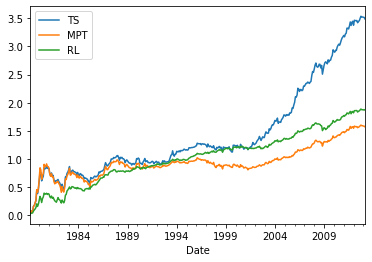

In [68]:
df_result = pd.DataFrame({
    'TS': profit_ts_list,
    'MPT': profit_mpt_list,
    'RL':profit_rl_list
}, index=data.index[120:530])
df_result.plot()

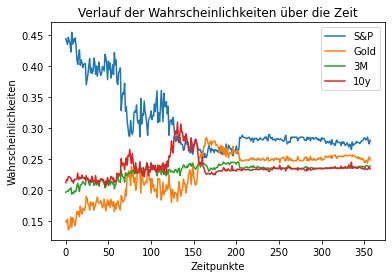

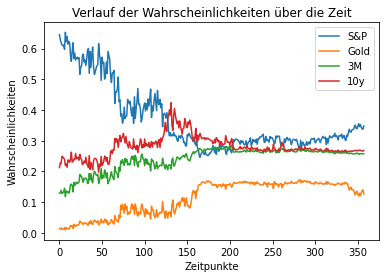

<AxesSubplot:>

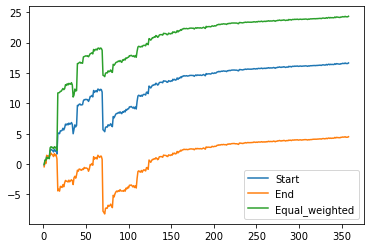

In [35]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240902_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

# fit model
# take difference of timeseries to avoid stationarity
df_stationary = df.diff().dropna()
var_model = estimate_VAR(data=df_stationary)

# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

df_stationary_training = df_stationary[0:split_obs-1]
df_stationary_test = df_stationary[split_obs-1::]

# define learning process
epochs = 200
numb_obs = 360
batch_size = 10
#discount_factor = 0.95

# get a new model
nn_model = NeuronalNet(CrossEntropyFlag= False, batch_size=batch_size)

# initialize arrays to store results
profit_series = []
probabilities_start = []
probabilities_end = []

# define a test data set
data_test = generate_data(df= df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs) 
x = data_test.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
data_test_scaled = pd.DataFrame(x_scaled)  

for j in range(epochs):
    # get a new data set
    data = generate_data(df=df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs)

    # scale data
    x = data.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    x_scaled = standard_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled)  

    # initialize arrays to store results
    sum_largest_prob = torch.zeros(4, dtype=float)
    target_array = torch.zeros(4, dtype=float)

    # i=0 first probability is pure random
    prob = torch.rand(4, requires_grad=False)
    prob /= torch.sum(prob)
    i=1
    obs = data.iloc[i,:].to_numpy().astype(float)
    profit_period = calc_return(df = data, i = i , prob = prob)
     # find best strategy
    profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
    vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
    
    # calculate discounted profit of each asset class
    #sum_largest_prob += torch.div(profit_period, batch_size)
    #target_array += torch.div(vec, batch_size)
    sum_largest_prob += profit_period
    target_array += vec

    for i in range(2, numb_obs-1):
        # calculate profit from current portfolio in each asset class
        obs = data.iloc[i,:].to_numpy().astype(float)
        prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
       
        if i < numb_obs:   
            profit_period = calc_return(df = data, i = i , prob = prob)
        else:
            profit_period = torch.zeros(4, dtype=float)
          

        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
     
        # calculate discounted profit of each asset class
        #sum_largest_prob += torch.div(profit_period, batch_size)
        #target_array += torch.div(vec, batch_size)
        sum_largest_prob += profit_period
        target_array += vec
        
        if i % batch_size ==0:
            # learn
            nn_model.train(torch.div(sum_largest_prob, batch_size), torch.div(target_array, batch_size))
            # initialize to get fresh results
            sum_largest_prob = torch.zeros(4, dtype=float)
            target_array = torch.zeros(4, dtype=float)   

    # check if system is learning in epoch 0...
    if (j==1)or(j==epochs-1):
        store_profit_series = []
        # store profit over time
        profit = torch.zeros(1)
        for i in range(1, numb_obs-1):
            # use only data from test data set to make it comparable
            obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
            prob = nn_model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
            store_profit_series.append(profit.item()) 
            if j ==1:
                probabilities_start.append(prob.detach().numpy())
            if j ==epochs-1:
                probabilities_end.append(prob.detach().numpy())
            
        profit_series.append(np.array(store_profit_series, dtype=float))  
   
#nn_model.plot()
plot_probabilities(probabilities = probabilities_start)
plot_probabilities(probabilities = probabilities_end)
store_profit_series = []
profit = 0
# store profit of equally weighted portfolio
for i in range(1, numb_obs-1):
    # use only data from test data set to make it comparable
    obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
    prob = torch.ones(4) / 4
    profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
    store_profit_series.append(profit.item()) 
profit_series.append(np.array(store_profit_series, dtype=float))       

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1],
    'Equal_weighted' : profit_series[2]
}, index=data_test.index[1:numb_obs-1])
df_result.plot()

Early Stop!


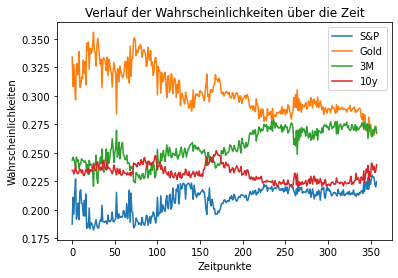

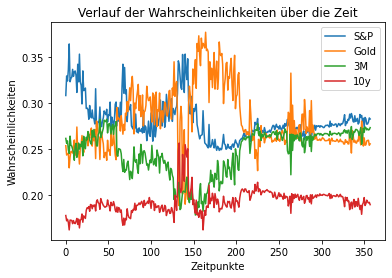

<AxesSubplot:>

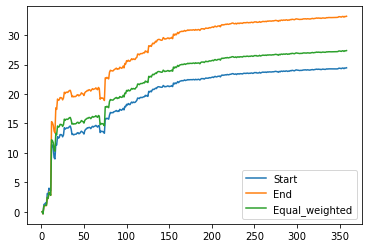

In [57]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240902_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

# fit model
# take difference of timeseries to avoid stationarity
df_stationary = df.diff().dropna()
var_model = estimate_VAR(data=df_stationary)

# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

df_stationary_training = df_stationary[0:split_obs-1]
df_stationary_test = df_stationary[split_obs-1::]

# define learning process
epochs = 400
numb_obs = 360
batch_size = 10
patience = 50000
#discount_factor = 0.95

# define early_stopping
early_stopping = EarlyStopping(patience=patience)


# get a new model
nn_model = NeuronalNet(CrossEntropyFlag= False, batch_size = batch_size)

# initialize arrays to store results
profit_series = []
probabilities_start = []
probabilities_end = []

# define a test data set
data_test = generate_data(df= df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs) 
x = data_test.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
data_test_scaled = pd.DataFrame(x_scaled)  

for j in range(epochs):
    if early_stopping.early_stop:
        break
    # get a new data set
    data = generate_data(df=df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs)

    # scale data
    x = data.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    x_scaled = standard_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled)  

    # initialize arrays to store results
    sum_largest_prob = torch.zeros(4, dtype=float)
    target_array = torch.zeros(4, dtype=float)

    # i=0 first probability is pure random
    prob = torch.rand(4, requires_grad=False)
    prob /= torch.sum(prob)
    i=1
    obs = data.iloc[i,:].to_numpy().astype(float)
    profit_period = calc_return(df = data, i = i , prob = prob)
     # find best strategy
    profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
    vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
    
    # calculate discounted profit of each asset class
    sum_largest_prob += profit_period
    target_array += vec

    for i in range(2, numb_obs-1):
        # calculate profit from current portfolio in each asset class
        obs = data.iloc[i,:].to_numpy().astype(float)
        prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
       
        if i < numb_obs:   
            profit_period = calc_return(df = data, i = i , prob = prob)
        else:
            profit_period = torch.zeros(4, dtype=float)
          

        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
     
        # calculate discounted profit of each asset class
        sum_largest_prob += profit_period
        target_array += vec
        
        if i % batch_size ==0:
            # learn
            nn_model.train(torch.div(sum_largest_prob, batch_size), torch.div(target_array, batch_size))
            # initialize to get fresh results
            sum_largest_prob = torch.zeros(4, dtype=float)
            target_array = torch.zeros(4, dtype=float)   
        early_stopping(nn_model.get_loss(), nn_model)

        if early_stopping.early_stop:
            print("Early Stop!")
            break

    # check if system is learning from 1st to last epoch
    if (j==1)or(j==epochs-1):
        store_profit_series = []
        # store profit over time
        profit = torch.zeros(1)
        for i in range(1, numb_obs-1):
            # use only data from test data set to make it comparable
            obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
            prob = nn_model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
            store_profit_series.append(profit.item()) 
            if j ==1:
                probabilities_start.append(prob.detach().numpy())
            if j ==epochs-1:
                probabilities_end.append(prob.detach().numpy())
            
        profit_series.append(np.array(store_profit_series, dtype=float))  

if early_stopping.early_stop:
    model = early_stopping.load_best_model(nn_model)
    store_profit_series = []
    # store profit over time
    profit = torch.zeros(1)
    for i in range(1, numb_obs-1):
        # use only data from test data set to make it comparable
        obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
        prob = model(torch.from_numpy(obs).float()) # get probability distribution
        profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
        store_profit_series.append(profit.item()) 
        probabilities_end.append(prob.detach().numpy())
     
    profit_series.append(np.array(store_profit_series, dtype=float))  

#nn_model.plot()
plot_probabilities(probabilities = probabilities_start)
plot_probabilities(probabilities = probabilities_end)
store_profit_series = []
profit = 0
# store profit of equally weighted portfolio
for i in range(1, numb_obs-1):
    # use only data from test data set to make it comparable
    obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
    prob = torch.ones(4) / 4
    profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
    store_profit_series.append(profit.item()) 
profit_series.append(np.array(store_profit_series, dtype=float))       

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1],
    'Equal_weighted' : profit_series[2]
}, index=data_test.index[1:numb_obs-1])
df_result.plot()

In [51]:
len(probabilities_start)

358

#### current period plus discounted value of being in current state (discount * q)

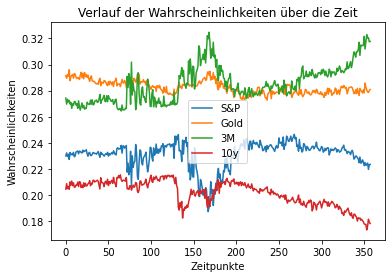

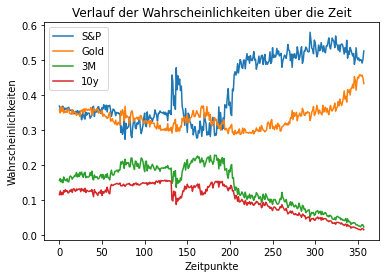

<AxesSubplot:>

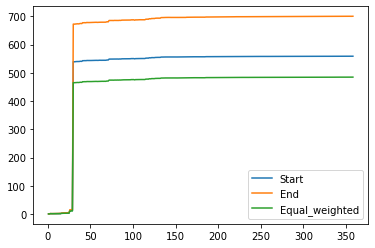

In [38]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240902_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

# fit model
# take difference of timeseries to avoid stationarity
df_stationary = df.diff().dropna()
var_model = estimate_VAR(data=df_stationary)

# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

df_stationary_training = df_stationary[0:split_obs-1]
df_stationary_test = df_stationary[split_obs-1::]

# define learning process
epochs = 50
numb_obs = 360
batch_size = 10
discount_factor = 0.95

# get a new model
nn_model = NeuronalNet(CrossEntropyFlag= False)

# initialize arrays to store results
profit_series = []
probabilities_start = []
probabilities_end = []

# define a test data set
data_test = generate_data(df= df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs) 
x = data_test.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
data_test_scaled = pd.DataFrame(x_scaled)  

for j in range(epochs):
    # get a new data set
    data = generate_data(df=df, df_stationary=df_stationary_training, model_fitted=var_model, numb_obs=numb_obs)

    # scale data
    x = data.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    x_scaled = standard_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled)  

    # initialize arrays to store results
    sum_largest_prob = torch.zeros(4, dtype=float)
    target_array = torch.zeros(4, dtype=float)

    for i in range(1, numb_obs-2):
      
        # calculate profit from current portfolio in each asset class
        obs = data.iloc[i,:].to_numpy().astype(float)
        prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
    
        if i < numb_obs:   
            profit_period = calc_return(df = data, i = i , prob = prob)
        else:
            profit_period = torch.zeros(4, dtype=float)
        

        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
    
        # find best strategy next period
        profit_best_next = calc_return(df = data, i = i+1 , prob = torch.ones(4)) # gets current pay-offs
        vec_next = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy

        # calculate discounted profit of each asset class
        sum_largest_prob += profit_period + discount_factor * vec_next
        target_array += profit_best + discount_factor * vec_next 
    
       
        if i%batch_size==0: 
            # learn
            nn_model.train(sum_largest_prob/batch_size, target_array/batch_size)
            # initialize to get fresh results
            sum_largest_prob = torch.zeros(4, dtype=float)
            target_array = torch.zeros(4, dtype=float)   

    # check if system is learning in epoch 0...
    if (j==1)or(j==epochs-1):
        store_profit_series = []
        # store profit over time
        profit = torch.zeros(1)
        for i in range(1, numb_obs-1):
            # use only data from test data set to make it comparable
            obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
            prob = nn_model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
            store_profit_series.append(profit.item()) 
            if j ==1:
                probabilities_start.append(prob.detach().numpy())
            if j ==epochs-1:
                probabilities_end.append(prob.detach().numpy())
            
        profit_series.append(np.array(store_profit_series, dtype=float))  
   
#nn_model.plot()
plot_probabilities(probabilities = probabilities_start)
plot_probabilities(probabilities = probabilities_end)
store_profit_series = []
profit = 0
# store profit of equally weighted portfolio
for i in range(1, numb_obs-1):
    # use only data from test data set to make it comparable
    obs = data_test_scaled.iloc[i,:].to_numpy().astype(float)
    prob = torch.ones(4) / 4
    profit += torch.sum(calc_return(df = data_test, i = i , prob = prob))
    store_profit_series.append(profit.item()) 
profit_series.append(np.array(store_profit_series, dtype=float))       

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1],
    'Equal_weighted' : profit_series[2]
}, index=data_test.index[1:numb_obs-1])
df_result.plot()

<AxesSubplot:>

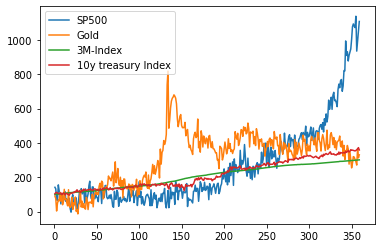

In [29]:
data_test.iloc[:, 0:4].plot()

### no transaction costs
### agent can move in and out of asset classes with no cost, no discount of future rewards

<AxesSubplot:>

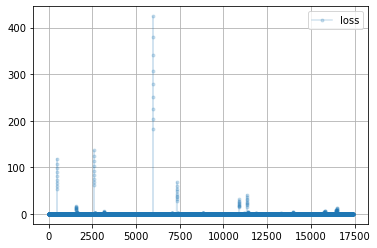

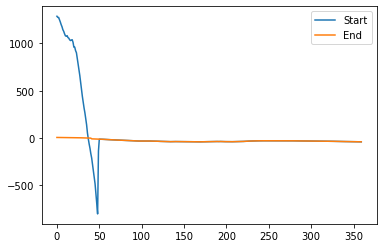

In [6]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240819_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.rename(columns={'Unnamed: 8': '10Y_Index'}, inplace=True)

# fit model
# take difference of timeseries to avoid stationarity
df_test_stationary = df.diff().dropna()

# fit VAR
var_model = VAR(df_test_stationary)
var_model_fitted = var_model.fit()

# define learning process
epochs = 50
numb_obs = 360
batch_size = 10
discount_factor = 0.95

model = NeuronalNet(CrossEntropyFlag= False)

profit_series = []
# define a test data set
data_test = generate_data(df= df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs) 

for j in range(epochs):
    data = generate_data(df=df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs)
    
    for i in range(1, numb_obs-batch_size-1):
        k = 1
        reward_array = torch.zeros(4, dtype=float)
        target_array = torch.zeros(4, dtype=float)
        
        while k < batch_size:
            # calculate profit from current portfolio in each asset class
            if i + k <= numb_obs:
                obs = data.iloc[i + k,:].to_numpy().astype(float)
                prob = model.forward(torch.from_numpy(obs).float()) # get probability distribution
                profit_period = calc_return(df = data, i = i + k, prob = prob)
            else:
                profit_period = torch.zeros(4, dtype=float)

            # add discounted profit to calculate profit in batch
            discounted_profit = (math.pow(discount_factor,k-1) * profit_period )/ batch_size
            #reward_array +=  torch.FloatTensor(discounted_profit, requires_grad=True)
            reward_array +=  torch.FloatTensor(discounted_profit)
            #reward_array.requires_grad =True

            # calculate discounted profit of each asset class
            discounted_profit_target = (math.pow(discount_factor,k-1) * calc_return(df= data, i = i + k, prob = torch.ones(4))) / batch_size
            target_array += torch.FloatTensor(discounted_profit_target)
            k += 1

        model.train(reward_array, target_array)
        

    # check if system is learning in epoch 0, 500, and 1000
    if (j==0) or (j==epochs -1):
        store_profit_series = []
        # store profit over time
        for i in range(numb_obs):
            # use only data from test data set to make it comparable
            obs = data_test.iloc[i,:].to_numpy().astype(float)
            prob = model(torch.from_numpy(obs).float()) # get probability distribution
            store_profit_series.append(np.dot(obs[0:4],prob.detach().numpy())) 
            
        profit_series.append(store_profit_series)

model.plot()

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1]
}, index=data_test.index)
df_result.plot()

In [56]:
def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0, 0]
    elif order == 1:
        return [0, 1, 0, 0]
    elif order == 2:
        return [0, 0, 1, 0]
    elif order == 3:
        return [0, 0, 0, 1]

<AxesSubplot:>

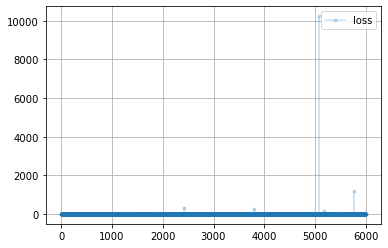

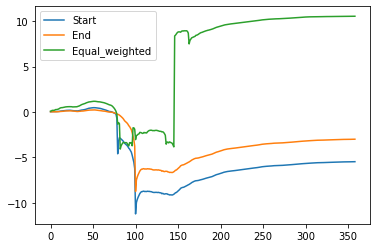

In [73]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240819_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.rename(columns={'Unnamed: 8': '10Y_Index'}, inplace=True)

# fit model
# take difference of timeseries to avoid stationarity
df_test_stationary = df.diff().dropna()

# fit VAR
var_model = VAR(df_test_stationary)
var_model_fitted = var_model.fit()

# define learning process
epochs = 50
numb_obs = 360
batch_size = 3
discount_factor = 0.95

# get a new model
model = NeuronalNet(CrossEntropyFlag= False)

# initialize arrays to store results
profit_series = []

# define a test data set
data_test = generate_data(df= df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs) 

for j in range(epochs):
    # get a new data set
    data = generate_data(df=df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs)

    # initialize arrays to store results
    sum_largest_prob = torch.zeros(4, dtype=float)
    target_array = torch.zeros(4, dtype=float)

    for i in range(numb_obs-1):
        # calculate profit from current portfolio in each asset class
        obs = data.iloc[i,:].to_numpy().astype(float)
        prob = model.forward(torch.from_numpy(obs).float()) # get probability distribution
        if i < numb_obs:   
            profit_period = calc_return(df = data, i = i , prob = prob)
        else:
            profit_period = torch.zeros(4, dtype=float)
        

        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4)) # gets current pay-offs
        vec = torch.FloatTensor(find_best_dis(profit_best)) * profit_best # profit of current best strategy
     
        # calculate discounted profit of each asset class
        sum_largest_prob =  discount_factor * sum_largest_prob + torch.FloatTensor(profit_period)
        target_array = discount_factor * target_array + torch.FloatTensor(vec)
        
        if i % batch_size == 0:
            # learn
            model.train(sum_largest_prob /batch_size, target_array/batch_size)
            # initialize to get fresh results
            sum_largest_prob = torch.zeros(4, dtype=float)
            target_array = torch.zeros(4, dtype=float)
        

    # check if system is learning in epoch 0...
    if (j==0)or(j==epochs-1):
        store_profit_series = []
        # store profit over time
        profit = 0
        for i in range(numb_obs-1):
            # use only data from test data set to make it comparable
            obs = data_test.iloc[i,:].to_numpy().astype(float)
            prob = model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = data_test, i = i , prob = prob)).detach().numpy()
            store_profit_series.append(profit) 
            
        profit_series.append(np.array(store_profit_series, dtype=float))

model.plot()

store_profit_series = []
profit = 0
# store profit of equally weighted portfolio
for i in range(numb_obs-1):
    # use only data from test data set to make it comparable
    obs = data_test.iloc[i,:].to_numpy().astype(float)
    prob = torch.ones(4) / 4
    profit += torch.sum(calc_return(df = data_test, i = i , prob = prob)).detach().numpy()
    store_profit_series.append(profit) 
profit_series.append(np.array(store_profit_series, dtype=float))       

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1],
    'Equal_weighted' : profit_series[2]
}, index=data_test.index[0:numb_obs-1])
df_result.plot()

In [69]:
df_result

,Start,End,Equal_weighted
0,0.013498,0.013498,0.145715
1,0.014694,0.014694,0.537252
2,0.030898,0.030898,0.527558
3,0.045824,0.045824,0.485326
4,0.052473,0.052473,0.437055
...,...,...,...
354,1.320593,1.321770,-13.946960
355,1.322482,1.323659,-13.942671
356,1.324228,1.325405,-13.939082
357,1.326887,1.328064,-13.936092


### Zweite Version, in der die beste Strategie ermittelt wird und danach optimiert wird

In [14]:
def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0, 0]
    elif order == 1:
        return [0, 1, 0, 0]
    elif order == 2:
        return [0, 0, 1, 0]
    elif order == 3:
        return [0, 0, 0, 1]

<AxesSubplot:>

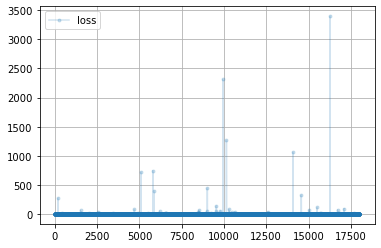

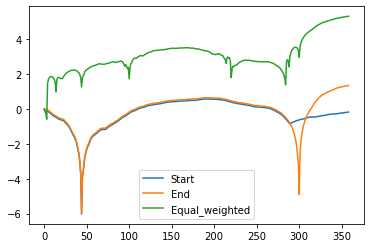

In [54]:
import warnings

# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# get data
df = pd.read_csv('../Data/20240819_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.rename(columns={'Unnamed: 8': '10Y_Index'}, inplace=True)

# fit model
# take difference of timeseries to avoid stationarity
df_test_stationary = df.diff().dropna()

# fit VAR
var_model = VAR(df_test_stationary)
var_model_fitted = var_model.fit()

# define learning process
epochs = 100
numb_obs = 360
batch_size = 2
discount_factor = 0.95

model = NeuronalNet(CrossEntropyFlag= False)

profit_series = []
# define a test data set
data_test = generate_data(df= df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs) 

for j in range(epochs):
    data = generate_data(df=df, df_test_stationary=df_test_stationary, model_fitted=var_model_fitted, numb_obs=numb_obs)
    sum_largest_prob = torch.zeros(4, dtype=float)
    target_array = torch.zeros(4, dtype=float)
    for i in range(numb_obs-1):
        # calculate profit from current portfolio in each asset class
        obs = data.iloc[i,:].to_numpy().astype(float)
        prob = model.forward(torch.from_numpy(obs).float()) # get probability distribution
        if i < numb_obs:   
            profit_period = calc_return(df = data, i = i , prob = prob)
        else:
            profit_period = torch.zeros(4, dtype=float)
        
        # calc profit of portfolios determined by model
        profit_actual= calc_return(df = data, i = i , prob = prob)
        largest_prob = torch.FloatTensor(find_best_dis(prob.detach().numpy())) * profit_actual  # weighted by return

        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(4))
        vec = torch.FloatTensor(find_best_dis(profit_best)) * profit_best
     
        # calculate discounted profit of each asset class
        sum_largest_prob =  discount_factor * sum_largest_prob + torch.FloatTensor(largest_prob)
        target_array = discount_factor * target_array + torch.FloatTensor(vec)
        
        if i % batch_size == 0:
            model.train(sum_largest_prob /batch_size, target_array/batch_size)
            sum_largest_prob = torch.zeros(4, dtype=float)
            target_array = torch.zeros(4, dtype=float)
        

    # check if system is learning in epoch 0...
    if (j==0)or(j==epochs-1):
        store_profit_series = []
        # store profit over time
        profit = 0
        for i in range(numb_obs-1):
            # use only data from test data set to make it comparable
            obs = data_test.iloc[i,:].to_numpy().astype(float)
            prob = model(torch.from_numpy(obs).float()) # get probability distribution
            profit += torch.sum(calc_return(df = data_test, i = i , prob = prob)).detach().numpy()
            store_profit_series.append(profit) 
            
        profit_series.append(np.array(store_profit_series, dtype=float))

model.plot()

store_profit_series = []
profit = 0
# store profit over time
for i in range(numb_obs-1):
    # use only data from test data set to make it comparable
    obs = data_test.iloc[i,:].to_numpy().astype(float)
    prob = torch.ones(4) / 4
    profit += torch.sum(calc_return(df = data_test, i = i , prob = prob)).detach().numpy()
    store_profit_series.append(profit) 
profit_series.append(np.array(store_profit_series, dtype=float))       

df_result = pd.DataFrame({
    'Start': profit_series[0],
    'End': profit_series[1],
    'Equal_weighted' : profit_series[2]
}, index=data_test.index[0:numb_obs-1])
df_result.plot()

In [41]:
find_best_dis(profit_actual)

[0, 1, 0, 0]

In [40]:
data

,SP500,Gold,3M,10y,CPI,Unemployment,3M-Index,10Y_Index
0,97.111171,95.328908,7.61753,6.627207,4.803338,4.71449,127.900494,129.132229
1,104.96253,96.63976,7.370194,6.608659,4.623027,4.867799,128.779442,130.255968
2,106.634979,109.445297,7.313164,6.609924,4.544175,4.824987,129.293963,130.931686
3,99.190262,109.863412,7.251072,6.564582,4.543707,4.787227,130.038117,132.210651
4,119.101659,115.248235,7.277818,6.585523,4.556157,4.823757,130.412981,132.421666
...,...,...,...,...,...,...,...,...
355,-5192.74541,-1425.449644,-26.480341,-25.804243,-27.612953,16.050121,492.768511,856.270538
356,-5220.58431,-1436.409142,-26.778468,-25.862824,-27.614927,16.267904,495.417209,859.277476
357,-5278.406491,-1447.406849,-27.20318,-26.006529,-27.58283,16.34213,498.351629,863.411094
358,-5311.377657,-1460.126956,-27.533264,-26.027397,-27.57556,16.657792,501.252522,866.365831
